
# Release Highlights for scikit-learn 1.4

.. currentmodule:: sklearn

We are pleased to announce the release of scikit-learn 1.4! Many bug fixes
and improvements were added, as well as some new key features. We detail
below a few of the major features of this release. **For an exhaustive list of
all the changes**, please refer to the `release notes <release_notes_1_4>`.

To install the latest version (with pip)::

    pip install --upgrade scikit-learn

or with conda::

    conda install -c conda-forge scikit-learn


## HistGradientBoosting Natively Supports Categorical DTypes in DataFrames
:class:`ensemble.HistGradientBoostingClassifier` and
:class:`ensemble.HistGradientBoostingRegressor` now directly supports dataframes with
categorical features.  Here we have a dataset with a mixture of
categorical and numerical features:



In [1]:
from sklearn.datasets import fetch_openml

X_adult, y_adult = fetch_openml("adult", version=2, return_X_y=True)

# Remove redundant and non-feature columns
X_adult = X_adult.drop(["education-num", "fnlwgt"], axis="columns")
X_adult.dtypes

age                  int64
workclass         category
education         category
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain         int64
capital-loss         int64
hours-per-week       int64
native-country    category
dtype: object

By setting `categorical_features="from_dtype"`, the gradient boosting classifier
treats the columns with categorical dtypes as categorical features in the
algorithm:



In [2]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X_adult, y_adult, random_state=0)
hist = HistGradientBoostingClassifier(categorical_features="from_dtype")

hist.fit(X_train, y_train)
y_decision = hist.decision_function(X_test)
print(f"ROC AUC score is {roc_auc_score(y_test, y_decision)}")

ROC AUC score is 0.9284760421660873


## Polars output in `set_output`
scikit-learn's transformers now support polars output with the `set_output` API.



In [3]:
import polars as pl
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

df = pl.DataFrame(
    {"height": [120, 140, 150, 110, 100], "pet": ["dog", "cat", "dog", "cat", "cat"]}
)
preprocessor = ColumnTransformer(
    [
        ("numerical", StandardScaler(), ["height"]),
        ("categorical", OneHotEncoder(sparse_output=False), ["pet"]),
    ],
    verbose_feature_names_out=False,
)
preprocessor.set_output(transform="polars")

df_out = preprocessor.fit_transform(df)
df_out

height,pet_cat,pet_dog
f64,f64,f64
-0.215666,0.0,1.0
0.862662,1.0,0.0
1.401826,0.0,1.0
-0.754829,1.0,0.0
-1.293993,1.0,0.0


In [4]:
print(f"Output type: {type(df_out)}")

Output type: <class 'polars.dataframe.frame.DataFrame'>


## Missing value support for Random Forest
The classes :class:`ensemble.RandomForestClassifier` and
:class:`ensemble.RandomForestRegressor` now support missing values. When training
every individual tree, the splitter evaluates each potential threshold with the
missing values going to the left and right nodes. More details in the
`User Guide <tree_missing_value_support>`.



In [5]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

X = np.array([0, 1, 6, np.nan]).reshape(-1, 1)
y = [0, 0, 1, 1]

forest = RandomForestClassifier(random_state=0).fit(X, y)
forest.predict(X)

array([0, 0, 1, 1])

## Add support for monotonic constraints in tree-based models
While we added support for monotonic constraints in histogram-based gradient boosting
in scikit-learn 0.23, we now support this feature for all other tree-based models as
trees, random forests, extra-trees, and exact gradient boosting. Here, we show this
feature for random forest on a regression problem.



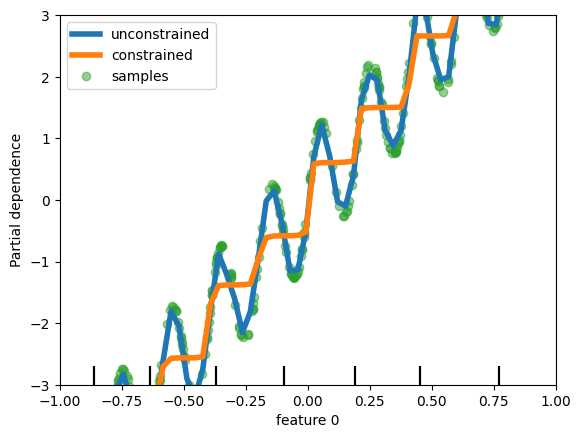

In [6]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor

n_samples = 500
rng = np.random.RandomState(0)
X = rng.randn(n_samples, 2)
noise = rng.normal(loc=0.0, scale=0.01, size=n_samples)
y = 5 * X[:, 0] + np.sin(10 * np.pi * X[:, 0]) - noise

rf_no_cst = RandomForestRegressor().fit(X, y)
rf_cst = RandomForestRegressor(monotonic_cst=[1, 0]).fit(X, y)

disp = PartialDependenceDisplay.from_estimator(
    rf_no_cst,
    X,
    features=[0],
    feature_names=["feature 0"],
    line_kw={"linewidth": 4, "label": "unconstrained", "color": "tab:blue"},
)
PartialDependenceDisplay.from_estimator(
    rf_cst,
    X,
    features=[0],
    line_kw={"linewidth": 4, "label": "constrained", "color": "tab:orange"},
    ax=disp.axes_,
)
disp.axes_[0, 0].plot(
    X[:, 0], y, "o", alpha=0.5, zorder=-1, label="samples", color="tab:green"
)
disp.axes_[0, 0].set_ylim(-3, 3)
disp.axes_[0, 0].set_xlim(-1, 1)
disp.axes_[0, 0].legend()
plt.show()

## Enriched estimator displays
Estimators displays have been enriched: if we look at `forest`, defined above:



In [7]:
forest

RandomForestClassifier(random_state=0)

One can access the documentation of the estimator by clicking on the icon "?" on
the top right corner of the diagram.

In addition, the display changes color, from orange to blue, when the estimator is
fitted. You can also get this information by hovering on the icon "i".



In [8]:
from sklearn.base import clone

clone(forest)  # the clone is not fitted

RandomForestClassifier(random_state=0)

## Metadata Routing Support
Many meta-estimators and cross-validation routines now support metadata
routing, which are listed in the `user guide
<metadata_routing_models>`. For instance, this is how you can do a nested
cross-validation with sample weights and :class:`~model_selection.GroupKFold`:



In [9]:
import sklearn
from sklearn.metrics import get_scorer
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, cross_validate, GroupKFold

# For now by default metadata routing is disabled, and need to be explicitly
# enabled.
sklearn.set_config(enable_metadata_routing=True)

n_samples = 100
X, y = make_regression(n_samples=n_samples, n_features=5, noise=0.5)
rng = np.random.RandomState(7)
groups = rng.randint(0, 10, size=n_samples)
sample_weights = rng.rand(n_samples)
estimator = Lasso().set_fit_request(sample_weight=True)
hyperparameter_grid = {"alpha": [0.1, 0.5, 1.0, 2.0]}
scoring_inner_cv = get_scorer("neg_mean_squared_error").set_score_request(
    sample_weight=True
)
inner_cv = GroupKFold(n_splits=5)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=hyperparameter_grid,
    cv=inner_cv,
    scoring=scoring_inner_cv,
)

outer_cv = GroupKFold(n_splits=5)
scorers = {
    "mse": get_scorer("neg_mean_squared_error").set_score_request(sample_weight=True)
}
results = cross_validate(
    grid_search,
    X,
    y,
    cv=outer_cv,
    scoring=scorers,
    return_estimator=True,
    params={"sample_weight": sample_weights, "groups": groups},
)
print("cv error on test sets:", results["test_mse"])

# Setting the flag to the default `False` to avoid interference with other
# scripts.
sklearn.set_config(enable_metadata_routing=False)

cv error on test sets: [-0.29361441 -0.40663634 -0.44913754 -0.38792122 -0.39269539]


## Improved memory and runtime efficiency for PCA on sparse data
PCA is now able to handle sparse matrices natively for the `arpack`
solver by levaraging `scipy.sparse.linalg.LinearOperator` to avoid
materializing large sparse matrices when performing the
eigenvalue decomposition of the data set covariance matrix.




In [10]:
from sklearn.decomposition import PCA
import scipy.sparse as sp
from time import time

X_sparse = sp.random(m=1000, n=1000, random_state=0)
X_dense = X_sparse.toarray()

t0 = time()
PCA(n_components=10, svd_solver="arpack").fit(X_sparse)
time_sparse = time() - t0

t0 = time()
PCA(n_components=10, svd_solver="arpack").fit(X_dense)
time_dense = time() - t0

print(f"Speedup: {time_dense / time_sparse:.1f}x")

Speedup: 3.7x
